# comparaison de metaheuristique

In [12]:
seed = random.randint(0, 100000)
print(f"Seed : {seed}")

Seed : 95642


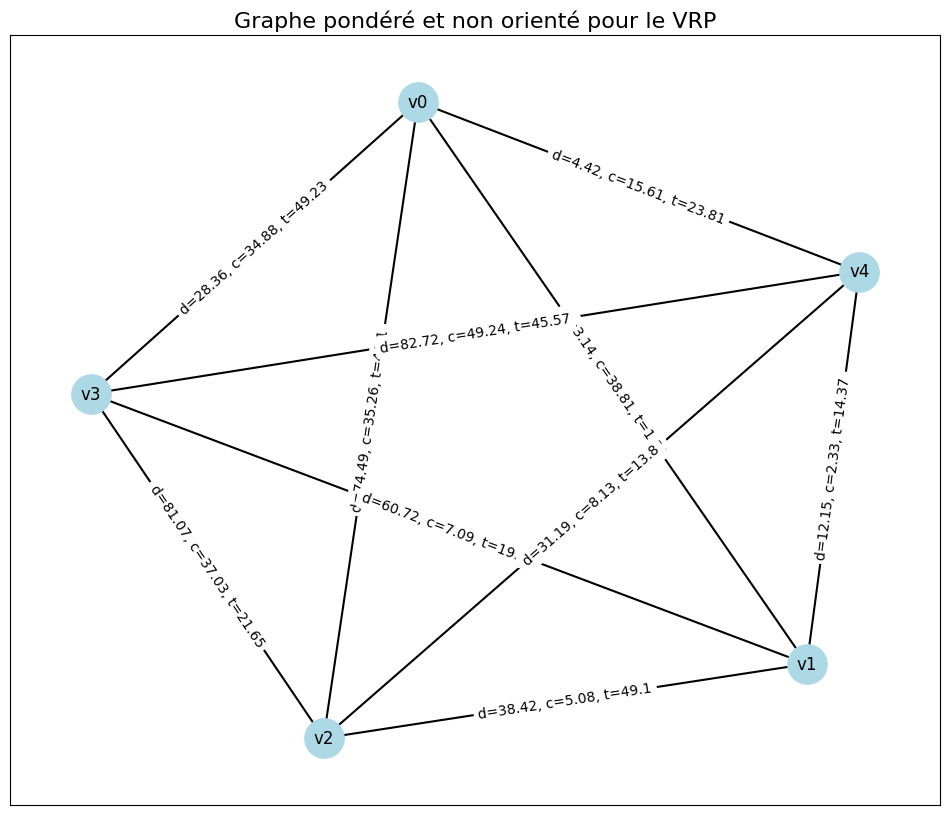

In [13]:
import matplotlib.pyplot as plt
import random
import networkx as nx

num_clients = 4 
depot = 0
nodes = [depot] + [i for i in range(1, num_clients + 1)]
G = nx.Graph()
for node in nodes:
    G.add_node(node)

for i in nodes:
    for j in nodes:
        if i < j:  
            distance = round(random.uniform(1, 100), 2)  
            cost = round(random.uniform(1, 50), 2)       
            time = round(random.uniform(1, 60), 2)     
            G.add_edge(i, j, distance=distance, cost=cost, time=time)

mapping = {node: f"v{node}" for node in G.nodes}
G = nx.relabel_nodes(G, mapping)
pos = nx.spring_layout(G, seed=42)  
plt.figure(figsize=(12, 10)) 
nx.draw_networkx_nodes(G, pos, node_size=800, node_color='lightblue')
nx.draw_networkx_edges(G, pos, width=1.5)
nx.draw_networkx_labels(G, pos, font_size=12, font_color='black')
edge_labels = {
    (u, v): f"d={data['distance']}, c={data['cost']}, t={data['time']}"
    for u, v, data in G.edges(data=True)
}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=10)
plt.title("Graphe pondéré et non orienté pour le VRP", fontsize=16)
plt.show()

In [14]:
def generate_weight(restricted_edge, weight_range):
    if random.random() < restricted_edge: time = 999
    else: time = random.randint(*weight_range)
    if random.random() < restricted_edge: distance = 999
    else: distance = random.randint(*weight_range)
    if random.random() < restricted_edge: cost = 999
    else: cost = random.randint(*weight_range)
    return time, distance, cost

def generate_graph(n, weight_range=(1, 100), restricted_edge=0.1, seed=None):
    if seed is not None:
        random.seed(seed)
        
    G = nx.complete_graph(n)

    # Ajouter des poids aléatoires aux arêtes
    for u, v in G.edges():
        time, distance, cost = generate_weight(restricted_edge, weight_range)
        G[u][v]['time'] = time
        G[u][v]['distance'] = distance
        G[u][v]['cost'] = cost
    
    return G

In [15]:
def ant_colony_vrp_fast(graph, depot, max_nodes=5, num_ants=10, num_iterations=50, alpha=1, beta=2, evaporation_rate=0.5, pheromone_init=1.0):

    pheromones = {edge: pheromone_init for edge in graph.edges}
    best_routes = None
    best_cost = float('inf')
    for iteration in range(num_iterations):
        for ant in range(num_ants):
            unvisited = set(graph.nodes)
            unvisited.remove(depot)
            routes = []
            total_cost = 0

            while unvisited:
                current_route = [depot]
                current_node = depot

                while unvisited and len(current_route) - 1 < max_nodes: 
                    neighbors = [n for n in graph.neighbors(current_node) if n in unvisited]
                    if not neighbors:
                        break

                    probabilities = []
                    for neighbor in neighbors:
                        edge = (current_node, neighbor) if (current_node, neighbor) in pheromones else (neighbor, current_node)
                        pheromone = pheromones[edge]
                        distance = graph[current_node][neighbor]['distance']
                        probabilities.append((neighbor, (pheromone ** alpha) * ((1 / distance) ** beta)))

                    if not probabilities:
                        break

                    total_prob = sum(prob[1] for prob in probabilities)
                    next_node = random.choices(
                        [node for node, _ in probabilities],
                        [prob / total_prob for _, prob in probabilities]
                    )[0]

                    current_route.append(next_node)
                    total_cost += graph[current_node][next_node]['distance']
                    unvisited.remove(next_node)
                    current_node = next_node

                if current_node != depot:
                    current_route.append(depot)
                    total_cost += graph[current_node][depot]['distance']

                routes.append(current_route)

            if total_cost < best_cost:
                best_cost = total_cost
                best_routes = routes

        for edge in pheromones:
            pheromones[edge] *= (1 - evaporation_rate)

        for route in best_routes:
            for i in range(len(route) - 1):
                edge = (route[i], route[i + 1]) if (route[i], route[i + 1]) in pheromones else (route[i + 1], route[i])
                pheromones[edge] += 1 / best_cost

    return best_routes, best_cost

best_routes, best_cost = ant_colony_vrp_fast(G, depot=0, max_nodes=4, num_ants=10, num_iterations=100)
if best_routes:
    print("Routes optimisées :", best_routes)
    print("Distance totale :", best_cost)
    plot_vrp_solution(G, best_routes, depot=0)


KeyError: 0